In [12]:
#Cell_1.
# -*- coding: utf-8 -*-

import os
import cv2
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix

import tensorflow
seedval = 13
tensorflow.random.set_seed(seedval)
np.random.seed(seedval)
random.seed(seedval)
os.environ["PYTHONHASHSEED"] = str(seedval)

2024-10-31 13:57:18.729539: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kali/anaconda3/envs/ds2024/lib/python3.7/site-packages/cv2/../../lib64:
2024-10-31 13:57:18.729562: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [13]:
#Cell_2.
IMAGESIZE = 128  #読み込んだ画像は(IMAGESIZE,IMAGESIZE)のサイズにリサイズする

# ディレクトリ内の画像を読み込む
# inputpath: ディレクトリ文字列, imagesize: 画像サイズ, type_color: ColorかGray
def load_images(inputpath, imagesize, type_color):
    imglist = []
    filenamelist = []

    for root, dirs, files in os.walk(inputpath):
        for fn in sorted(files):
            bn, ext = os.path.splitext(fn)
            if ext not in [".bmp", ".BMP", ".jpg", ".JPG", ".jpeg", ".JPEG", ".png", ".PNG"]:
                continue

            filename = os.path.join(root, fn)
            
            if type_color == 'Color':
                # カラー画像の場合
                testimage = cv2.imread(filename, cv2.IMREAD_COLOR)
                # サイズ変更
                height, width = testimage.shape[:2]
                testimage = cv2.resize(testimage, (imagesize, imagesize), interpolation = cv2.INTER_AREA)  #主に縮小するのでINTER_AREA使用
                testimage = np.asarray(testimage, dtype=np.float64)
                # 色チャンネル，高さ，幅に入れ替え．data_format="channels_first"を使うとき必要
                #testimage = testimage.transpose(2, 0, 1)
                # チャンネルをbgrの順からrgbの順に変更
                testimage = testimage[:,:,::-1]
            
            elif type_color == 'Gray':
                # グレースケール画像の場合
                testimage = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
                # サイズ変更
                height, width = testimage.shape[:2]
                testimage = cv2.resize(testimage, (imagesize, imagesize), interpolation = cv2.INTER_AREA)  #主に縮小するのでINTER_AREA使用
                # チャンネルの次元がないので1次元追加する
                testimage = np.asarray([testimage], dtype=np.float64)
                testimage = np.asarray(testimage, dtype=np.float64).reshape((imagesize, imagesize, 1))
                # チャンネル，高さ，幅に入れ替え．data_format="channels_first"を使うとき必要
                #testimage = testimage.transpose(2, 0, 1)

            imglist.append(testimage)
            filenamelist.append(fn)
    imgsdata = np.asarray(imglist, dtype=np.float32)

    return imgsdata, filenamelist  # 画像リストとファイル名のリストを返す


In [14]:
#Cell_3.
#%%
### データ準備 ###
print('*** Loading images ***')

# 画像読み込みとラベル値作成
# クラス0
image0, filenames_image0 = load_images('./sundatabase_negative/', IMAGESIZE, 'Color')
label0 = np.full(image0.shape[0], 0)    #画像数と同数のラベル値を含むリスト

# クラス1
image1, filenames_image1 = load_images('./sundatabase_positive/', IMAGESIZE, 'Color')
label1 = np.full(image1.shape[0], 1)    #画像数と同数のラベル値を含むリスト


# 画像，ラベル値，ファイル名それぞれ1つの配列にまとめる
image_all = np.concatenate([image0, image1], axis=0)
label_all = np.append(label0, label1)
filename_all = filenames_image0 + filenames_image1


*** Loading images ***


In [15]:
#Cell_4.
indices = np.array(range(image_all.shape[0]))
image_train, image_test, label_train, label_test, index_train, index_test = train_test_split(image_all, label_all, indices, test_size=0.2)

In [16]:
#Cell_5.
print(indices)
print(len(label_train))
print(len(label_test))

[   0    1    2 ... 1810 1811 1812]
1450
363


In [17]:
#Cell_6.
# testデータのファイル名リスト作成
filenames_test = []
for i in range(len(index_test)):
    filenames_test.append(filename_all[index_test[i]])


# 画像の画素値を0-1に正規化
image_train /= 255.0
image_test /= 255.0

# ラベルをone hot vector形式に変換
label_train_binary = to_categorical(label_train)
label_test_binary = to_categorical(label_test)

print('Loaded images: ' + repr(image_train.shape[0]) + ' for training and ' + repr(image_test.shape[0]) + ' for testing.')


Loaded images: 1450 for training and 363 for testing.


In [18]:
#Cell_7.
### 画像分類モデル定義と学習処理の実行 ###
print('*** Training ***')

# 分類モデル定義
# 基本的な分類CNN
def classification_model():
    input_img = Input(shape=(IMAGESIZE, IMAGESIZE, 3))

    x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same')(input_img)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=4, strides=4)(x)

    x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=4, strides=4)(x)

    x = Flatten()(x)

    x = Dense(50)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(10)(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(2)(x)
    x = Activation('softmax')(x)
    
    model = Model(inputs=input_img, outputs=x)
    
    return model

# 分類モデル定義関数を呼び出す
model = classification_model()

# モデルを表示
print(model.summary())

*** Training ***
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8

2024-10-31 13:57:37.352945: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kali/anaconda3/envs/ds2024/lib/python3.7/site-packages/cv2/../../lib64:
2024-10-31 13:57:37.352976: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2024-10-31 13:57:37.352992: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kali): /proc/driver/nvidia/version does not exist
2024-10-31 13:57:37.353168: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-31 13:57:37.356

In [19]:
%%time
#Cell_8.
n_epochs=100
val_split=0.2
batch_size=128
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping

history_file="-history-w{}.csv".format(IMAGESIZE)
model.compile(loss='binary_crossentropy', optimizer='rmsprop',
              metrics=['accuracy'])
cl=CSVLogger(history_file)
es=EarlyStopping(monitor='val_loss', patience=12, verbose=1)

fit_log=model.fit(image_train, label_train_binary, batch_size=batch_size,
                  epochs=n_epochs, validation_split=val_split,
                  callbacks=[cl, es])
#model14.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# training実行
#training = model.fit(image_train, label_train_binary, epochs=100, batch_size=2, verbose=1)

2024-10-31 13:57:37.415617: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 228065280 exceeds 10% of free system memory.


Epoch 1/100


2024-10-31 13:57:38.017356: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 268435456 exceeds 10% of free system memory.
2024-10-31 13:57:38.226303: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 268435456 exceeds 10% of free system memory.


 1/10 [==>...........................] - ETA: 0s - loss: 0.7135 - accuracy: 0.4375

2024-10-31 13:57:38.490794: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 268435456 exceeds 10% of free system memory.
2024-10-31 13:57:38.675222: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 268435456 exceeds 10% of free system memory.


10/10 [==============================] - 4s 391ms/step - loss: 0.6099 - accuracy: 0.6250 - val_loss: 0.3171 - val_accuracy: 0.9276
Epoch 2/100
10/10 [==============================] - 4s 419ms/step - loss: 0.4106 - accuracy: 0.8009 - val_loss: 0.1683 - val_accuracy: 0.9828
Epoch 3/100
10/10 [==============================] - 4s 412ms/step - loss: 0.2767 - accuracy: 0.9155 - val_loss: 0.0677 - val_accuracy: 0.9931
Epoch 4/100
10/10 [==============================] - 4s 402ms/step - loss: 0.2257 - accuracy: 0.9224 - val_loss: 0.0290 - val_accuracy: 0.9931
Epoch 5/100
10/10 [==============================] - 4s 394ms/step - loss: 0.1920 - accuracy: 0.9397 - val_loss: 0.0412 - val_accuracy: 0.9966
Epoch 6/100
10/10 [==============================] - 4s 396ms/step - loss: 0.1592 - accuracy: 0.9595 - val_loss: 0.0270 - val_accuracy: 0.9931
Epoch 7/100
10/10 [==============================] - 4s 412ms/step - loss: 0.1294 - accuracy: 0.9672 - val_loss: 0.0197 - val_accuracy: 0.9966
Epoch 8/100

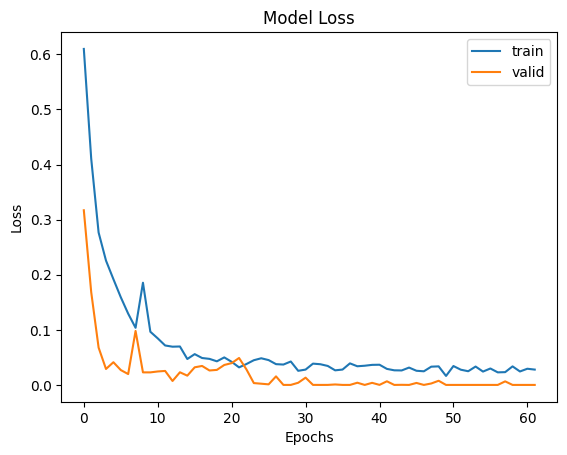

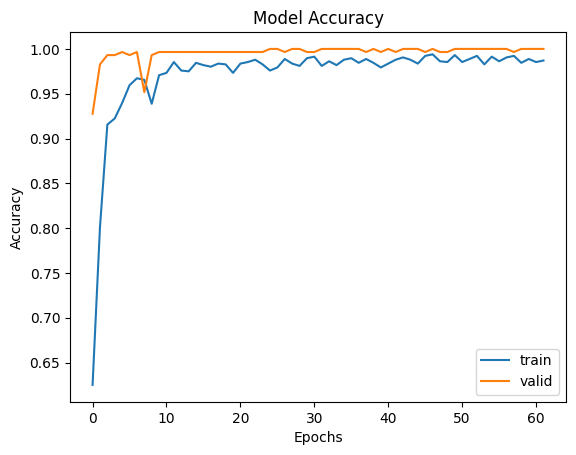

In [20]:
#Cell_10.
loss=fit_log.history['loss']
val_loss=fit_log.history['val_loss']
acc=fit_log.history['accuracy']
val_acc=fit_log.history['val_accuracy']
epoch=range(len(loss))

plt.plot(epoch, loss, label='train')
plt.plot(epoch, val_loss, label='valid')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epoch, acc, label='train')
plt.plot(epoch, val_acc, label='valid')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
#Cell_11.
target_layer = model.get_layer("conv2d_1")
intermediate_model = Model(inputs=[model.inputs], outputs=[target_layer.output, model.output])
label_test

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,

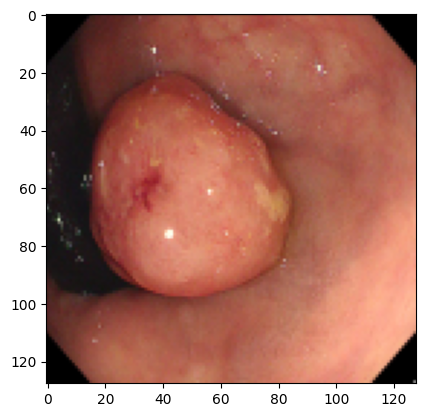

In [23]:
#Cell_12.
idx = 0
input_img = image_test[idx]
import matplotlib.pyplot as plt
plt.imshow(input_img)

In [25]:
#Cell_13.
import tensorflow as tf
import numpy as np

# Grad-CAMの計算
input_img_tensor = tf.convert_to_tensor(input_img.reshape(1, 128, 128, 3))  # NumPy配列をテンソルに変換
with tf.GradientTape() as tape:
    tape.watch(input_img_tensor)  # ここでテンソルをwatch
    conv_output, predictions = intermediate_model(input_img_tensor)
    class_idx = np.argmax(predictions[0])
    loss = predictions[:, class_idx]

In [26]:
#Cell_14.
grads = tape.gradient(loss, conv_output)[0] 

In [27]:
#Cell_15.
weights = np.mean(grads, axis=(0, 1))

In [28]:
#Cell_16.
cam = np.dot(conv_output[0], weights) # 線形結合(Linear combination)
cam = np.maximum(cam, 0)  # ReLU

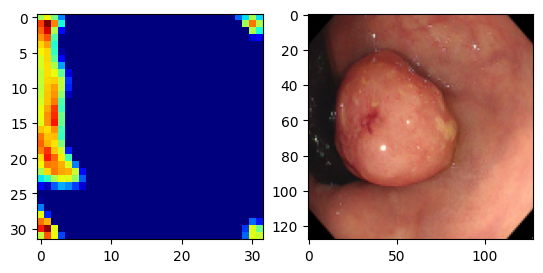

In [29]:
#Cell_17.
cam = cam / cam.max()  # 正規化

plt.subplot(121)
plt.imshow(cam, cmap="jet")

plt.subplot(122)
plt.imshow(input_img, cmap='gray')

plt.show()

In [30]:
#Cell_18.
from scipy.ndimage import zoom

# 特徴マップを64x64にアップサンプリング
zoom_factor = 64 / 16  # 64: ターゲットのサイズ, 4: 元のサイズ
cam_resized = zoom(cam, zoom_factor)


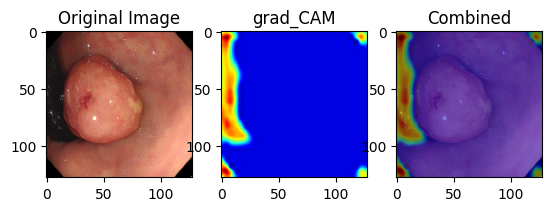

In [31]:
#Cell_19.
plt.subplot(131)
plt.title("Original Image")
plt.imshow(input_img, cmap="gray")

plt.subplot(132)
plt.title("grad_CAM")
plt.imshow(cam_resized, cmap="jet")

plt.subplot(133)
plt.title("Combined")
plt.imshow(input_img, cmap="gray")
plt.imshow(cam_resized, cmap='jet', alpha=0.5) 

plt.show()

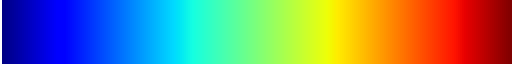

In [32]:
#Cell_20.
import matplotlib.colors as mcolors

# カラーマップ
cmap = plt.get_cmap('jet')
cmaplist = [cmap(i) for i in range(cmap.N)]
# 0の値を無色透明にする
cmaplist[0] = (1, 1, 1, 0.0)  # (R, G, B, Alpha)
cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_cmap', cmaplist, cmap.N)
cmap_custom

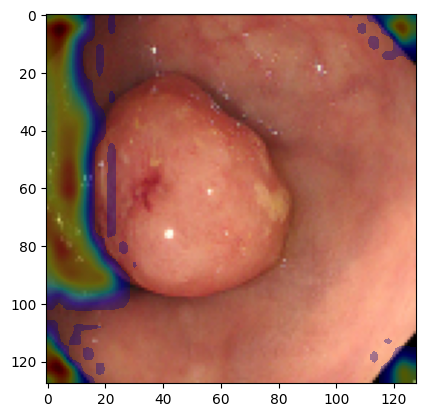

In [33]:
#Cell_21.
import matplotlib.colors as mcolors

# 元の画像
plt.imshow(input_img, cmap='gray')
# CAMを透過してオーバーレイ表示
plt.imshow(cam_resized, cmap=cmap_custom, alpha=0.35, vmin=0)

plt.show()